In [45]:
# import required libraries
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import Patch

import geopandas as gpd
from shapely.geometry import Point

import mapclassify
from libpysal.weights import Queen
from esda.moran import Moran_Local, Moran
from mgwr.gwr import GWR
from mgwr.sel_bw import Sel_BW
from sklearn.preprocessing import MinMaxScaler

import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [3]:
# Read the complete file
county_mental_health = gpd.read_file("complete_mental_health_counties.shp")

In [54]:
# verifying columns
county_mental_health.columns

Index(['index', 'STATEFP', 'COUNTYFP', 'COUNTYNS', 'AFFGEOID', 'GEOID', 'NAME',
       'NAMELSAD', 'STUSPS', 'STATE_NAME', 'LSAD', 'ALAND', 'AWATER',
       'depress', 'mentdist', 'svi', 'cri', 'statedesc', 'locationna',
       'geometry'],
      dtype='object')

In [55]:
#initial data inspection 
county_mental_health.head()

index STATEFP COUNTYFP  COUNTYNS        AFFGEOID  GEOID           NAME  \
0  1256.0      01      077  00161564  0500000US01077  01077     Lauderdale   
1   949.0      02      150  01419974  0500000US02150  02150  Kodiak Island   
2   809.0      06      009  01675885  0500000US06009  06009      Calaveras   
3   439.0      06      025  00277277  0500000US06025  06025       Imperial   
4  1304.0      06      053  00277291  0500000US06053  06053       Monterey   

                NAMELSAD STUSPS  STATE_NAME LSAD         ALAND        AWATER  \
0      Lauderdale County     AL     Alabama   06  1.730149e+09  1.336063e+08   
1  Kodiak Island Borough     AK      Alaska   04  1.732407e+10  1.414886e+10   
2       Calaveras County     CA  California   06  2.641837e+09  4.378949e+07   
3        Imperial County     CA  California   06  1.081460e+10  7.902168e+08   
4        Monterey County     CA  California   06  8.499623e+09  1.267794e+09   

   depress  mentdist       svi       cri   statedesc     locationna  \
0     26.2      19.4  0.227187  0.410512     Alabama     Lauderdale   
1     18.5      15.5  0.263577  0.290280      Alaska  Kodiak Island   
2     25.0      18.9  0.275070  0.305736  California      Calaveras   
3     20.7      18.1  0.554988  0.483753  California       Imperial   
4     21.0      18.1  0.387063  0.360918  California       Monterey   

                                            geometry  
0  POLYGON ((-88.20296 35.00803, -88.00003 35.005...  
1  MULTIPOLYGON (((-151.89613 58.19768, -151.8932...  
2  POLYGON ((-120.99359 38.22558, -120.99161 38.2...  
3  POLYGON ((-116.10617 32.64020, -116.10577 32.6...  
4  POLYGON ((-121.97659 36.58006, -121.97526 36.5...

In [4]:
# inspecting current reference system
county_mental_health.crs

<Geographic 2D CRS: EPSG:4269>
Name: NAD83
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: North America - onshore and offshore: Canada - Alberta; British Columbia; Manitoba; New Brunswick; Newfoundland and Labrador; Northwest Territories; Nova Scotia; Nunavut; Ontario; Prince Edward Island; Quebec; Saskatchewan; Yukon. Puerto Rico. United States (USA) - Alabama; Alaska; Arizona; Arkansas; California; Colorado; Connecticut; Delaware; Florida; Georgia; Hawaii; Idaho; Illinois; Indiana; Iowa; Kansas; Kentucky; Louisiana; Maine; Maryland; Massachusetts; Michigan; Minnesota; Mississippi; Missouri; Montana; Nebraska; Nevada; New Hampshire; New Jersey; New Mexico; New York; North Carolina; North Dakota; Ohio; Oklahoma; Oregon; Pennsylvania; Rhode Island; South Carolina; South Dakota; Tennessee; Texas; Utah; Vermont; Virginia; Washington; West Virginia; Wisconsin; Wyoming. US Virgin Islands. British Virgin Islands

In [5]:
#  cleaning data to only keep contious us
# Excluded: AK(02), HI(15), PR(72), AS(60), GU(66), MP(69), VI(78)
states_to_exclude = ['02', '15', '72', '60', '66', '69', '78']
contiguous_us_data = county_mental_health[
    ~county_mental_health['STATEFP'].isin(states_to_exclude)
]

In [12]:
#Validate Geometries
# We remove rows with invalid (null) geometries before proceeding.
invalid_geoms = contiguous_us_data.geometry.isnull()
if invalid_geoms.sum() > 0:
    print(f"Found and removed {invalid_geoms.sum()} rows with invalid geometries.")
    contiguous_us_data = contiguous_us_data[~invalid_geoms].copy()
else:
    print("No invalid geometries found. Data is clean.")

No invalid geometries found. Data is clean.


In [40]:
# Defining a New Projection for this Map Albers Equal Area
US_ALBERS_PROJECTION = ccrs.AlbersEqualArea(central_longitude=-96, central_latitude=37.5)
# final dataset we will use for analysis.
contiguous_us_proj = contiguous_us_data.to_crs(US_ALBERS_PROJECTION.proj4_init)

In [14]:
#North Arrow
def add_north_arrow(ax, location=(0.95, 0.95), arrow_size=60, text_size=28, 
                    text_color='black', arrow_color='black', background_color='white',
                    background_alpha=0.8, background_pad=0.02, font_weight='bold'):
    x, y = location    
    # The 'N' character
    ax.text(x, y, 'N', transform=ax.transAxes,
            horizontalalignment='center', verticalalignment='center',
            fontsize=text_size, fontweight=font_weight, color=text_color,
            zorder=1001)    
    # The arrow symbol 
    ax.text(x, y - 0.06, '▲', transform=ax.transAxes,  # Using triangle instead of caret
            horizontalalignment='center', verticalalignment='center',
            fontsize=arrow_size, color=arrow_color, fontweight='bold',
            zorder=1001)

In [26]:
# scaler
def add_scale_bar(ax, length_km=200, location=(0.1, 0.05), linewidth=4, fontsize=11):
    x0, y0 = location
    bar_width = 0.2  # fraction of axes width
    ax.annotate(
        '', xy=(x0 + bar_width, y0), xytext=(x0, y0),
        xycoords='axes fraction', textcoords='axes fraction',
        arrowprops=dict(arrowstyle='-', color='black', lw=linewidth)
    )
    ax.text(
        x0 + bar_width / 2, y0 - 0.02, f'{length_km} km',
        transform=ax.transAxes, ha='center', va='top', fontsize=fontsize
    )

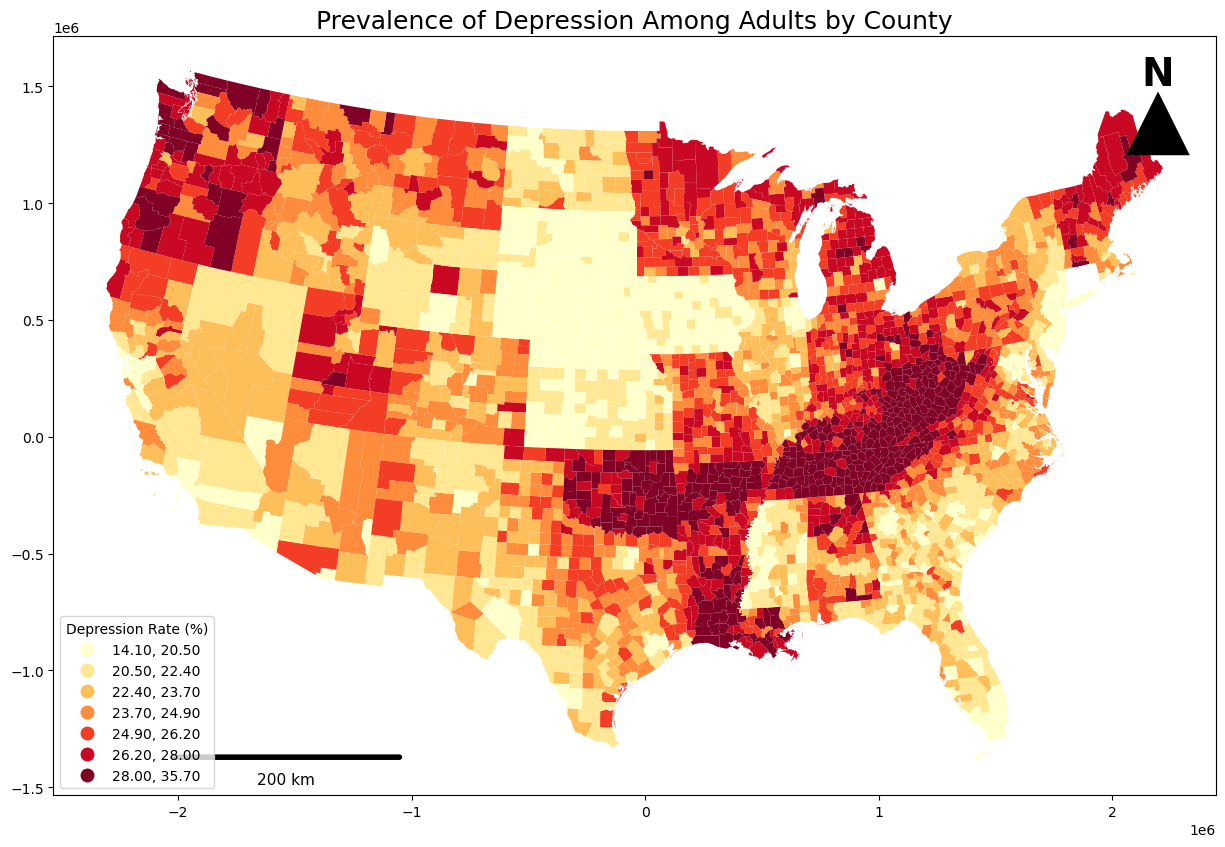

In [28]:
# Create depression chloropleth map
fig, ax = plt.subplots(1, 1, figsize=(15, 10))

contiguous_us_proj.plot(
    column='depress',
    ax=ax,
    legend=True,
    scheme='quantiles',
    k=7,
    cmap='YlOrRd',
    edgecolor='none',
    legend_kwds={'title': "Depression Rate (%)", 'loc': 'lower left'}
)

# Add map elements
add_scale_bar(ax, length_km=200)
add_north_arrow(ax)

# ✅ Removed set_extent — not needed
ax.set_title("Prevalence of Depression Among Adults by County", fontsize=18)

plt.show()

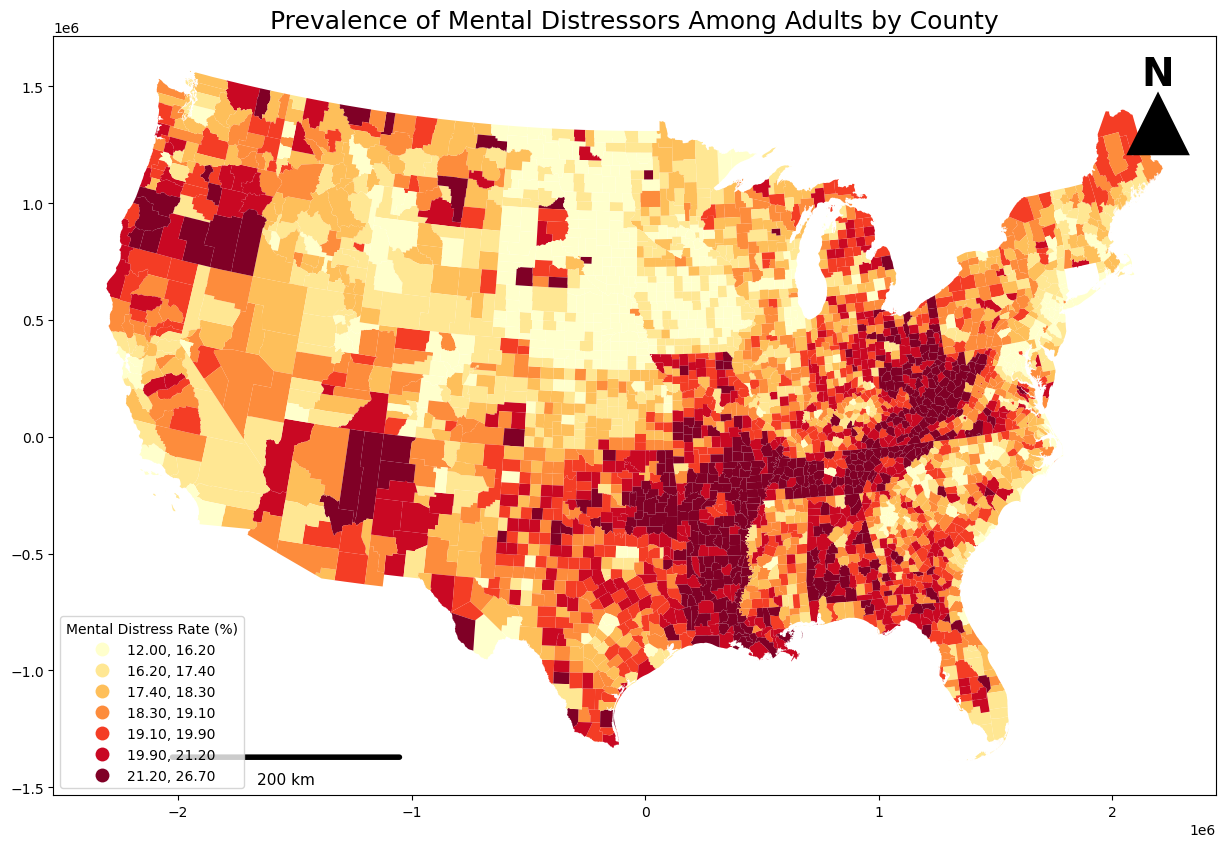

In [30]:
# Create mental distress chloropleth map
fig, ax = plt.subplots(1, 1, figsize=(15, 10))

contiguous_us_proj.plot(
    column='mentdist',
    ax=ax,
    legend=True,
    scheme='quantiles',
    k=7,
    cmap='YlOrRd',
    edgecolor='none',
    legend_kwds={'title': "Mental Distress Rate (%)", 'loc': 'lower left'}
)

# Add map elements
add_scale_bar(ax, length_km=200)
add_north_arrow(ax)

# ✅ Removed set_extent — not needed
ax.set_title("Prevalence of Mental Distressors Among Adults by County", fontsize=18)

plt.show()

## Exploratory Spatial Stats

/cvmfs/cybergis.illinois.edu/software/conda/cybergisx/python3-0.9.4/lib/python3.8/site-packages/esda/moran.py:1057: RuntimeWarning: invalid value encountered in true_divide
  self.z_sim = (self.Is - self.EI_sim) / self.seI_sim
/cvmfs/cybergis.illinois.edu/software/conda/cybergisx/python3-0.9.4/lib/python3.8/site-packages/esda/moran.py:1057: RuntimeWarning: invalid value encountered in true_divide
  self.z_sim = (self.Is - self.EI_sim) / self.seI_sim


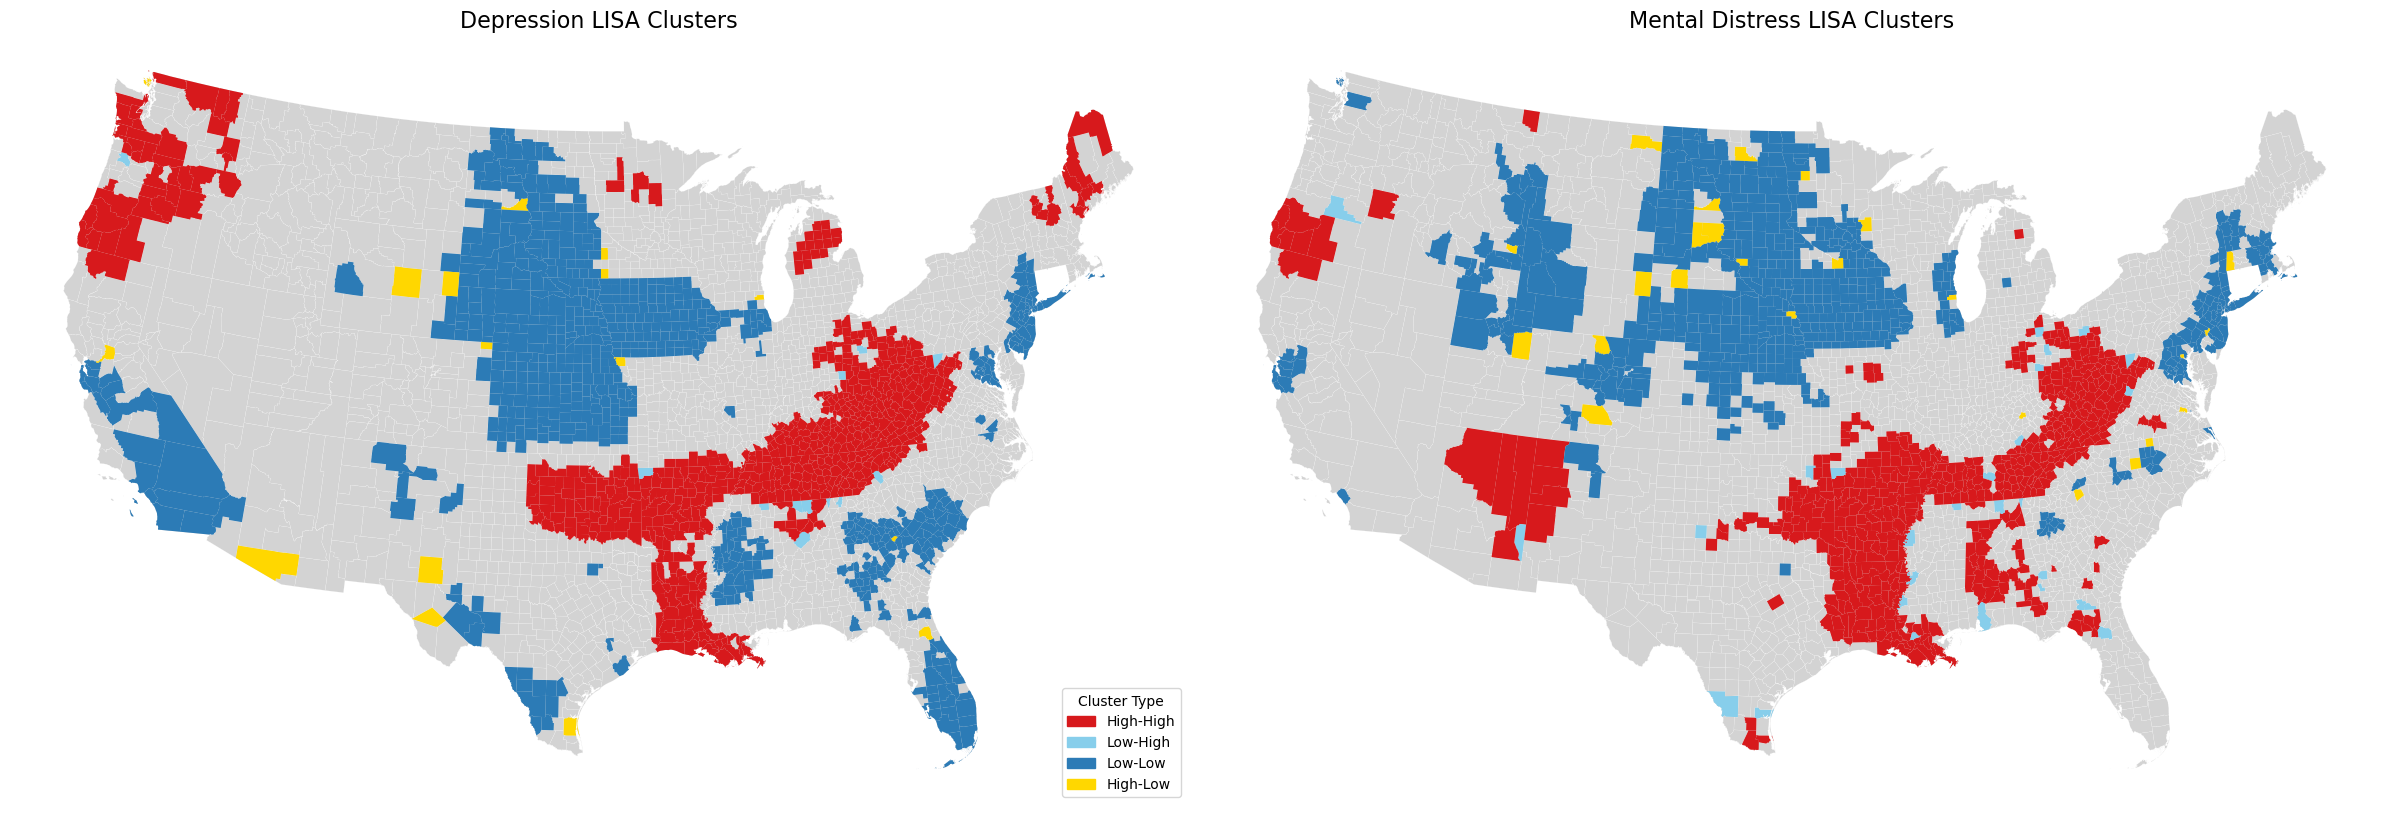

In [36]:
# LISA for Depression and Mental Distress - Side by Side
fig, axes = plt.subplots(1, 2, figsize=(24, 10))

variables = ['depress', 'mentdist']
titles = ['Depression LISA Clusters', 'Mental Distress LISA Clusters']

for i, (var, title) in enumerate(zip(variables, titles)):
    # Calculate LISA
    moran_local = Moran_Local(contiguous_us_proj[var], w)
    contiguous_us_proj[f'{var}_lisa_q'] = moran_local.q
    contiguous_us_proj[f'{var}_lisa_p'] = moran_local.p_sim
    
    # Get significant clusters
    significant = contiguous_us_proj[contiguous_us_proj[f'{var}_lisa_p'] < 0.05]
    
    # Plot base layer
    contiguous_us_proj.plot(ax=axes[i], color='lightgray', edgecolor='white', linewidth=0.1)
    
    # Plot significant clusters
    significant.plot(ax=axes[i], column=f'{var}_lisa_q', categorical=True,
                    cmap=plt.cm.colors.ListedColormap(list(cluster_colors.values())))
    
    # Add legend to first subplot only
    if i == 0:
        legend_elements = [mpatches.Patch(color=c, label=l) for l, c in 
                          zip(['High-High', 'Low-High', 'Low-Low', 'High-Low'], cluster_colors.values())]
        axes[i].legend(handles=legend_elements, loc='lower right', title="Cluster Type")
    
    axes[i].set_axis_off()
    axes[i].set_title(title, fontsize=16)

plt.tight_layout()
plt.show()

## Bivariate analysis

/tmp/ipykernel_413/2772497821.py:55: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.1, 1, 0.96])


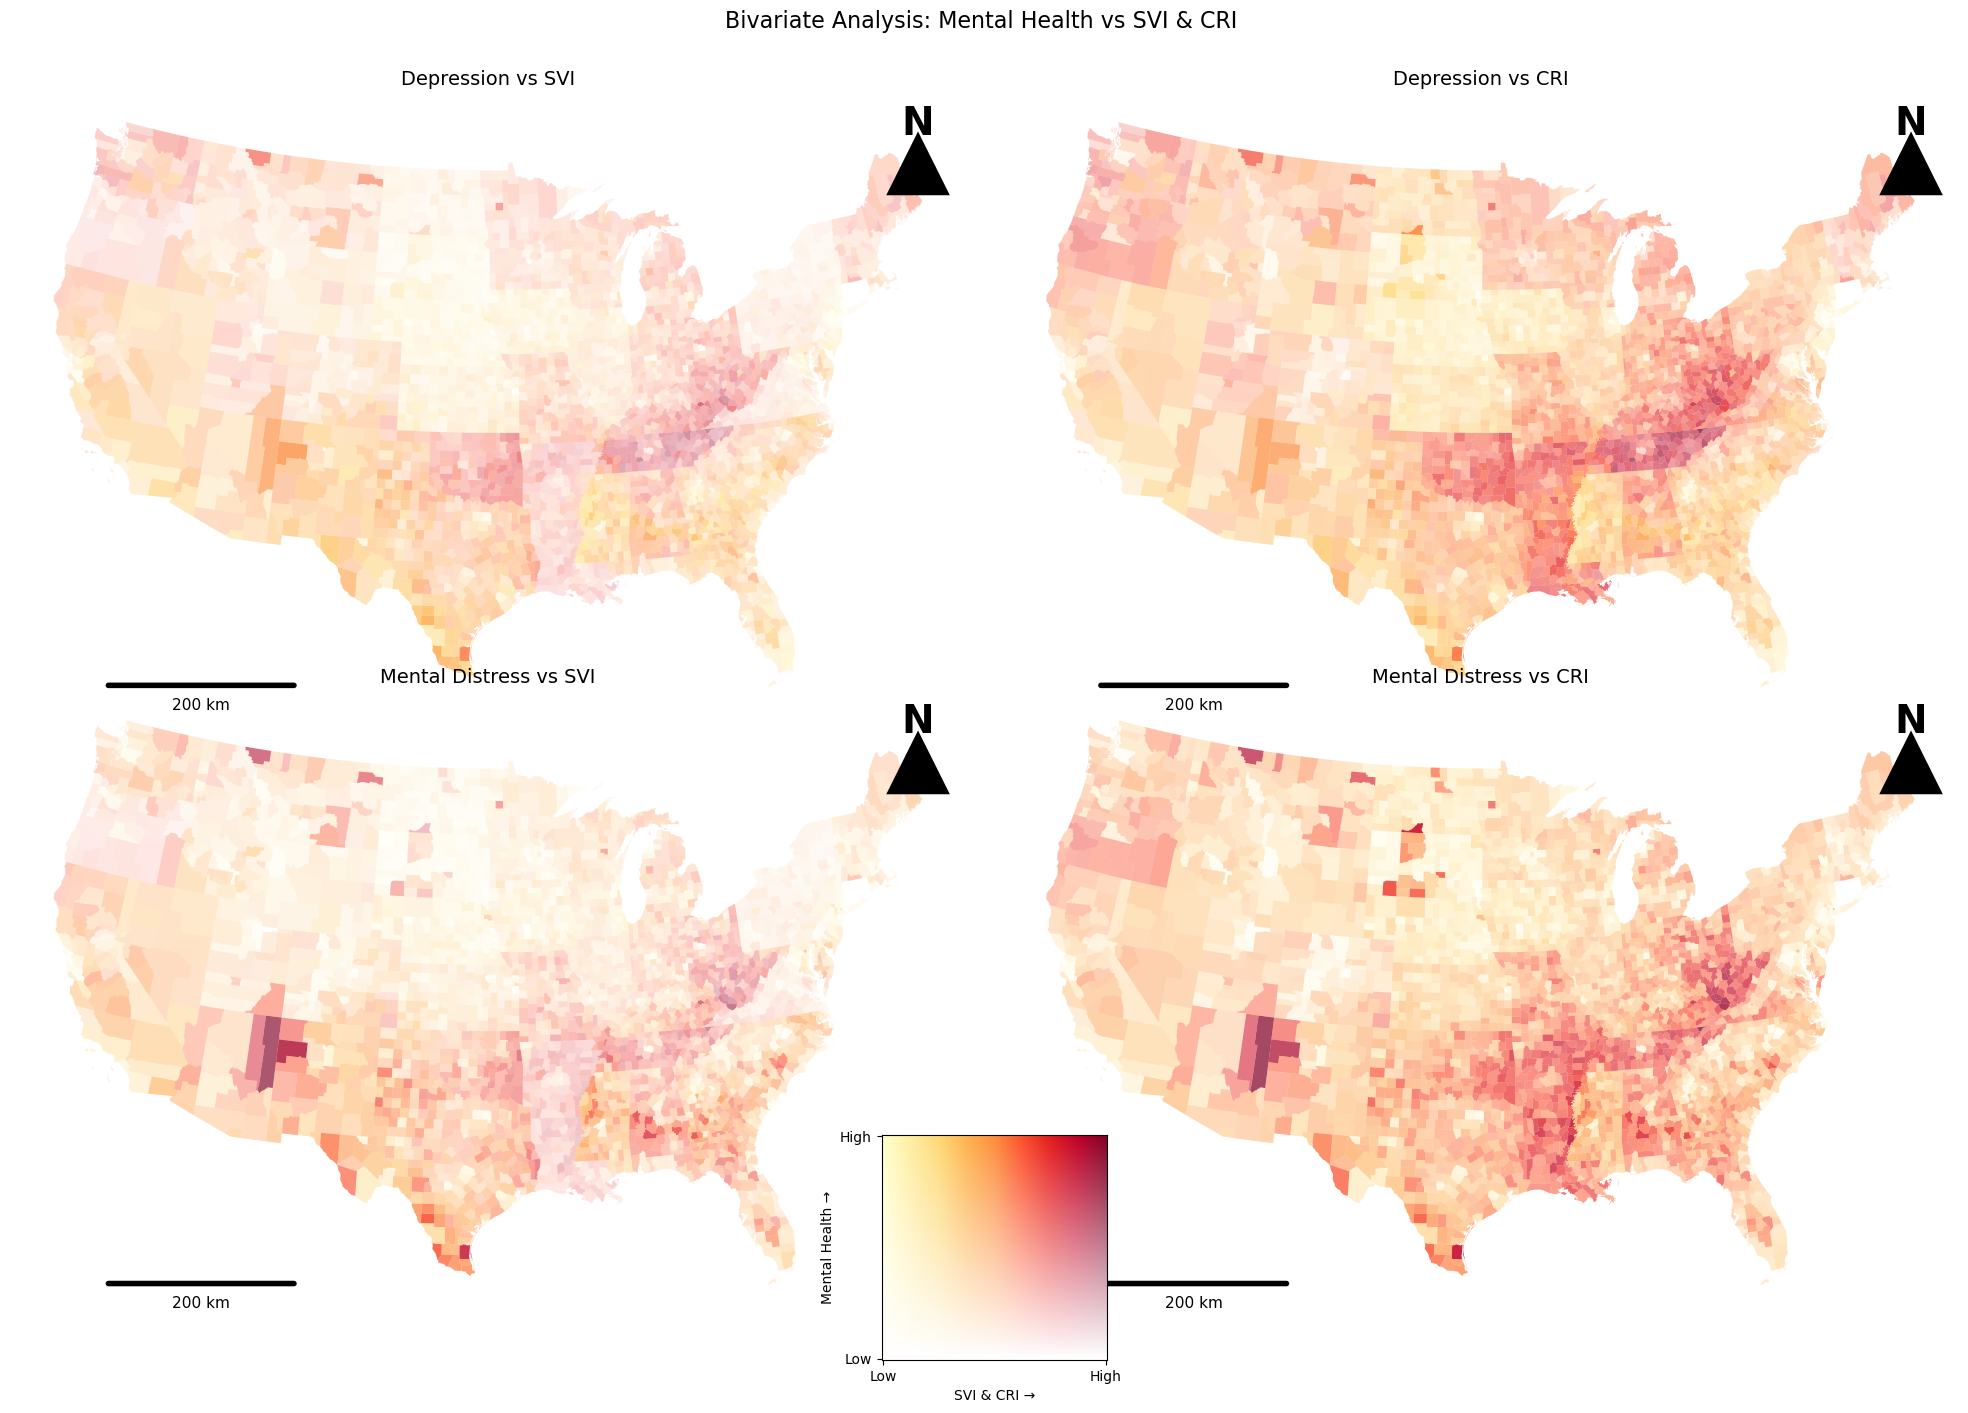

In [43]:
# Prepare data
scaler = MinMaxScaler()
contiguous_us_proj['depress_norm'] = scaler.fit_transform(contiguous_us_proj[['depress']])
contiguous_us_proj['mentdist_norm'] = scaler.fit_transform(contiguous_us_proj[['mentdist']])

# Create bivariate colors
colormap = plt.cm.YlOrRd

colors_dep_svi = colormap(contiguous_us_proj['depress_norm'])
colors_dep_svi[:, 3] = contiguous_us_proj['svi']

colors_dep_cri = colormap(contiguous_us_proj['depress_norm'])
colors_dep_cri[:, 3] = contiguous_us_proj['cri']

colors_dist_svi = colormap(contiguous_us_proj['mentdist_norm'])
colors_dist_svi[:, 3] = contiguous_us_proj['svi']

colors_dist_cri = colormap(contiguous_us_proj['mentdist_norm'])
colors_dist_cri[:, 3] = contiguous_us_proj['cri']

# Create 2x2 subplot without cartopy projection
fig, axes = plt.subplots(2, 2, figsize=(20, 15))
axs = axes.flatten()

# Plot maps
titles = ['Depression vs SVI', 'Depression vs CRI', 
          'Mental Distress vs SVI', 'Mental Distress vs CRI']
colors_list = [colors_dep_svi, colors_dep_cri, colors_dist_svi, colors_dist_cri]

for ax, title, colors in zip(axs, titles, colors_list):
    contiguous_us_proj.plot(ax=ax, color=colors, edgecolor='none')
    ax.set_title(title, fontsize=14)
    ax.set_axis_off()  # Remove axes for cleaner look
    add_scale_bar(ax)  # Your custom function
    add_north_arrow(ax)  # Your custom function

# Add legend
ax_legend = fig.add_axes([0.43, 0.08, 0.15, 0.15])
n_grid = 100
xx, yy = np.meshgrid(np.linspace(0, 1, n_grid), np.linspace(0, 1, n_grid))
legend_colors = colormap(yy)
legend_colors[:, :, 3] = xx
ax_legend.imshow(np.swapaxes(legend_colors, 0, 1), origin='lower')
ax_legend.set_xlabel('SVI & CRI →')
ax_legend.set_ylabel('Mental Health →')
ax_legend.set_xticks([0, n_grid-1])
ax_legend.set_yticks([0, n_grid-1])
ax_legend.set_xticklabels(['Low', 'High'])
ax_legend.set_yticklabels(['Low', 'High'])

fig.suptitle('Bivariate Analysis: Mental Health vs SVI & CRI ', fontsize=16)
plt.tight_layout(rect=[0, 0.1, 1, 0.96])
plt.show()

In [46]:
# Geographically Weighted Regression for depression
# Prepare data for GWR
y = contiguous_us_proj['depress'].values.reshape(-1, 1)
X = contiguous_us_proj[['svi', 'cri']].values
X = np.hstack([np.ones(y.shape), X])  # Add intercept
coords = np.vstack([contiguous_us_proj.geometry.centroid.x, contiguous_us_proj.geometry.centroid.y]).T

# Find optimal bandwidth and run GWR
try:
    print("Finding optimal GWR bandwidth...")
    selector = Sel_BW(coords, y, X)
    bandwidth = selector.search()
    print(f"Optimal bandwidth: {int(bandwidth)} neighbors")

    print("Running GWR model...")
    gwr_model = GWR(coords, y, X, bw=bandwidth)
    gwr_results = gwr_model.fit()

    print("\nGWR Results Summary:")
    gwr_results.summary()

except Exception as e:
    print(f"Error: {e}")

Finding optimal GWR bandwidth...
Optimal bandwidth: 50 neighbors
Running GWR model...

GWR Results Summary:
Model type                                                         Gaussian
Number of observations:                                                3100
Number of covariates:                                                     3

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                          27486.634
Log-likelihood:                                                   -7781.271
AIC:                                                              15568.542
AICc:                                                             15570.555
BIC:                                                               2589.363
R2:                                                                   0.244
Adj. R2:                                                              0.244

Variable                    

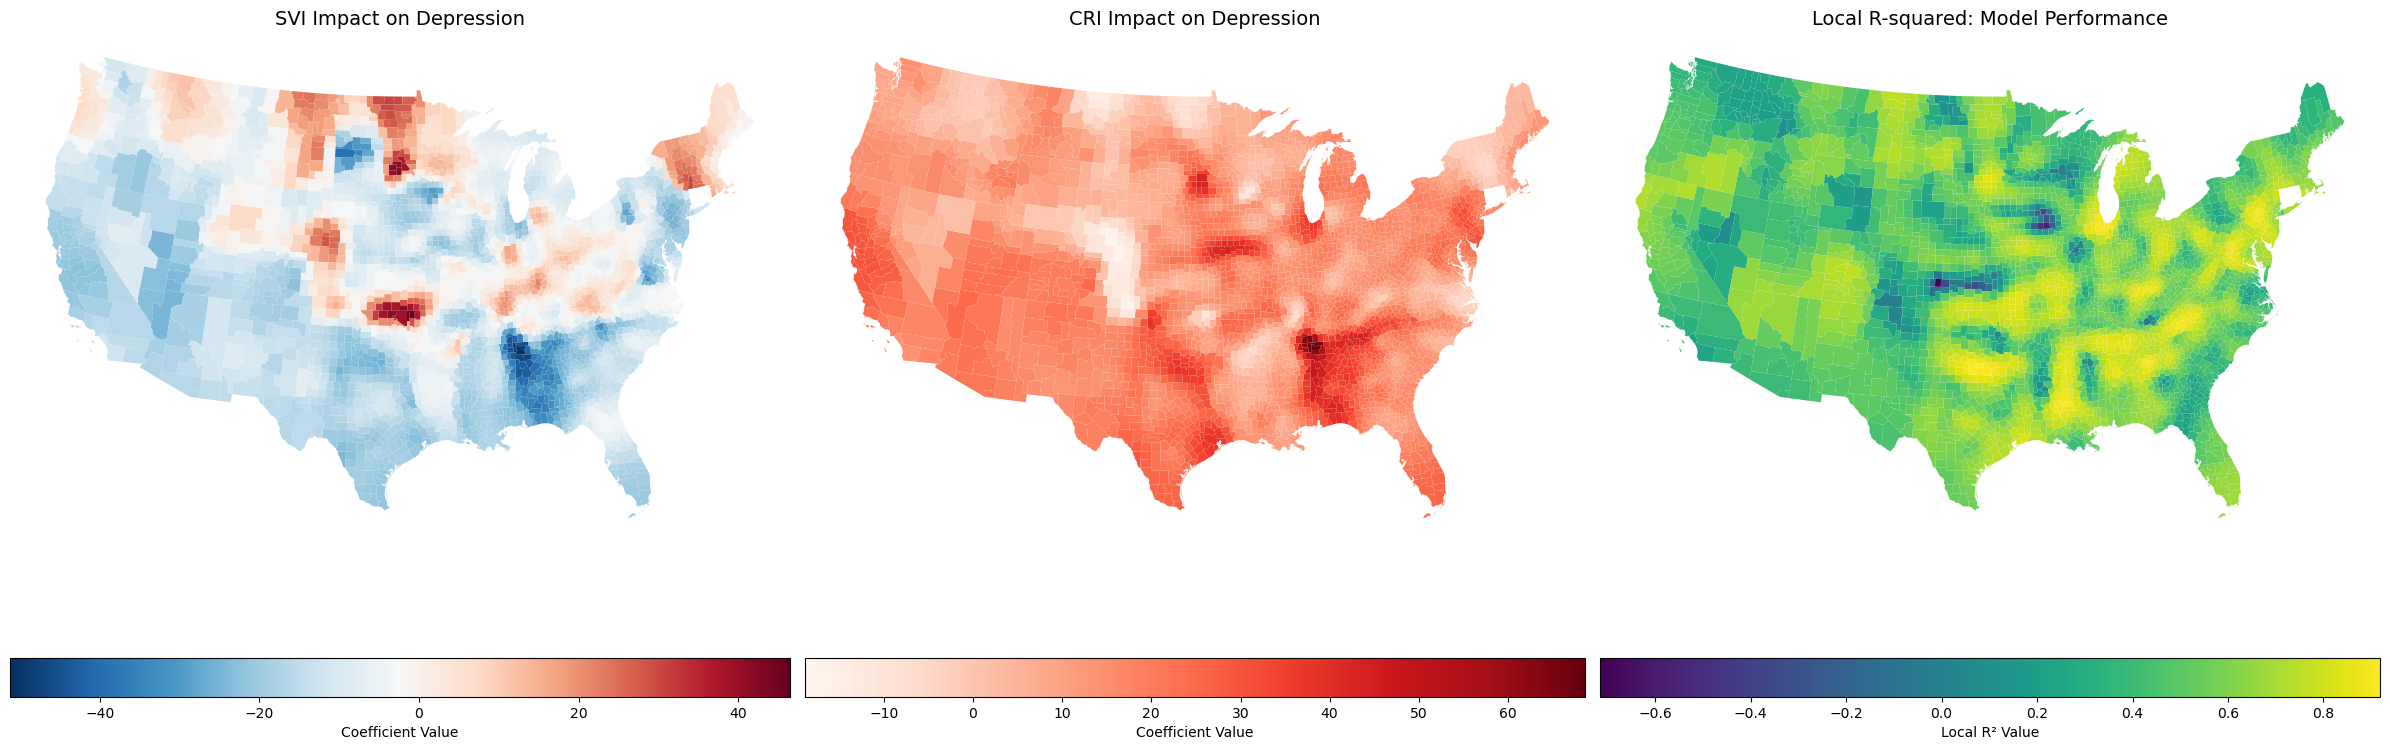

In [48]:
### Visualizing the GWR Model Results
# Add GWR results to dataframe
contiguous_us_proj['gwr_svi_coef'] = gwr_results.params[:, 1]
contiguous_us_proj['gwr_cri_coef'] = gwr_results.params[:, 2]
contiguous_us_proj['gwr_local_r2'] = gwr_results.localR2

# Create subplots for GWR results
fig, axes = plt.subplots(1, 3, figsize=(24, 8))

# SVI Coefficient
contiguous_us_proj.plot(column='gwr_svi_coef', cmap='RdBu_r', legend=True,
                       legend_kwds={'label': "Coefficient Value", 'orientation': "horizontal"},
                       ax=axes[0])
axes[0].set_axis_off()
axes[0].set_title('SVI Impact on Depression', fontsize=14)

# CRI Coefficient
contiguous_us_proj.plot(column='gwr_cri_coef', cmap='Reds', legend=True,
                       legend_kwds={'label': "Coefficient Value", 'orientation': "horizontal"},
                       ax=axes[1])
axes[1].set_axis_off()
axes[1].set_title('CRI Impact on Depression', fontsize=14)

# Local R-squared
contiguous_us_proj.plot(column='gwr_local_r2', cmap='viridis', legend=True,
                       legend_kwds={'label': "Local R² Value", 'orientation': "horizontal"},
                       ax=axes[2])
axes[2].set_axis_off()
axes[2].set_title('Local R-squared: Model Performance', fontsize=14)

plt.tight_layout()
plt.show()

In [49]:
# GWR for Mental Distress
# Prepare data for GWR
y_mentdist = contiguous_us_proj['mentdist'].values.reshape(-1, 1)
X_mentdist = contiguous_us_proj[['svi', 'cri']].values
X_mentdist = np.hstack([np.ones(y_mentdist.shape), X_mentdist])
coords = np.vstack([contiguous_us_proj.geometry.centroid.x, contiguous_us_proj.geometry.centroid.y]).T

# Find optimal bandwidth and run GWR
try:
    print("Finding optimal GWR bandwidth for Mental Distress...")
    selector_mentdist = Sel_BW(coords, y_mentdist, X_mentdist)
    bandwidth_mentdist = selector_mentdist.search()
    print(f"Optimal bandwidth: {int(bandwidth_mentdist)} neighbors")

    print("Running GWR model for Mental Distress...")
    gwr_model_mentdist = GWR(coords, y_mentdist, X_mentdist, bw=bandwidth_mentdist)
    gwr_results_mentdist = gwr_model_mentdist.fit()

    print("\nGWR Results Summary for Mental Distress:")
    gwr_results_mentdist.summary()

except Exception as e:
    print(f"Error: {e}")

Finding optimal GWR bandwidth for Mental Distress...
Optimal bandwidth: 50 neighbors
Running GWR model for Mental Distress...

GWR Results Summary for Mental Distress:
Model type                                                         Gaussian
Number of observations:                                                3100
Number of covariates:                                                     3

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                           4411.039
Log-likelihood:                                                   -4945.407
AIC:                                                               9896.814
AICc:                                                              9898.827
BIC:                                                             -20486.231
R2:                                                                   0.725
Adj. R2:                                     

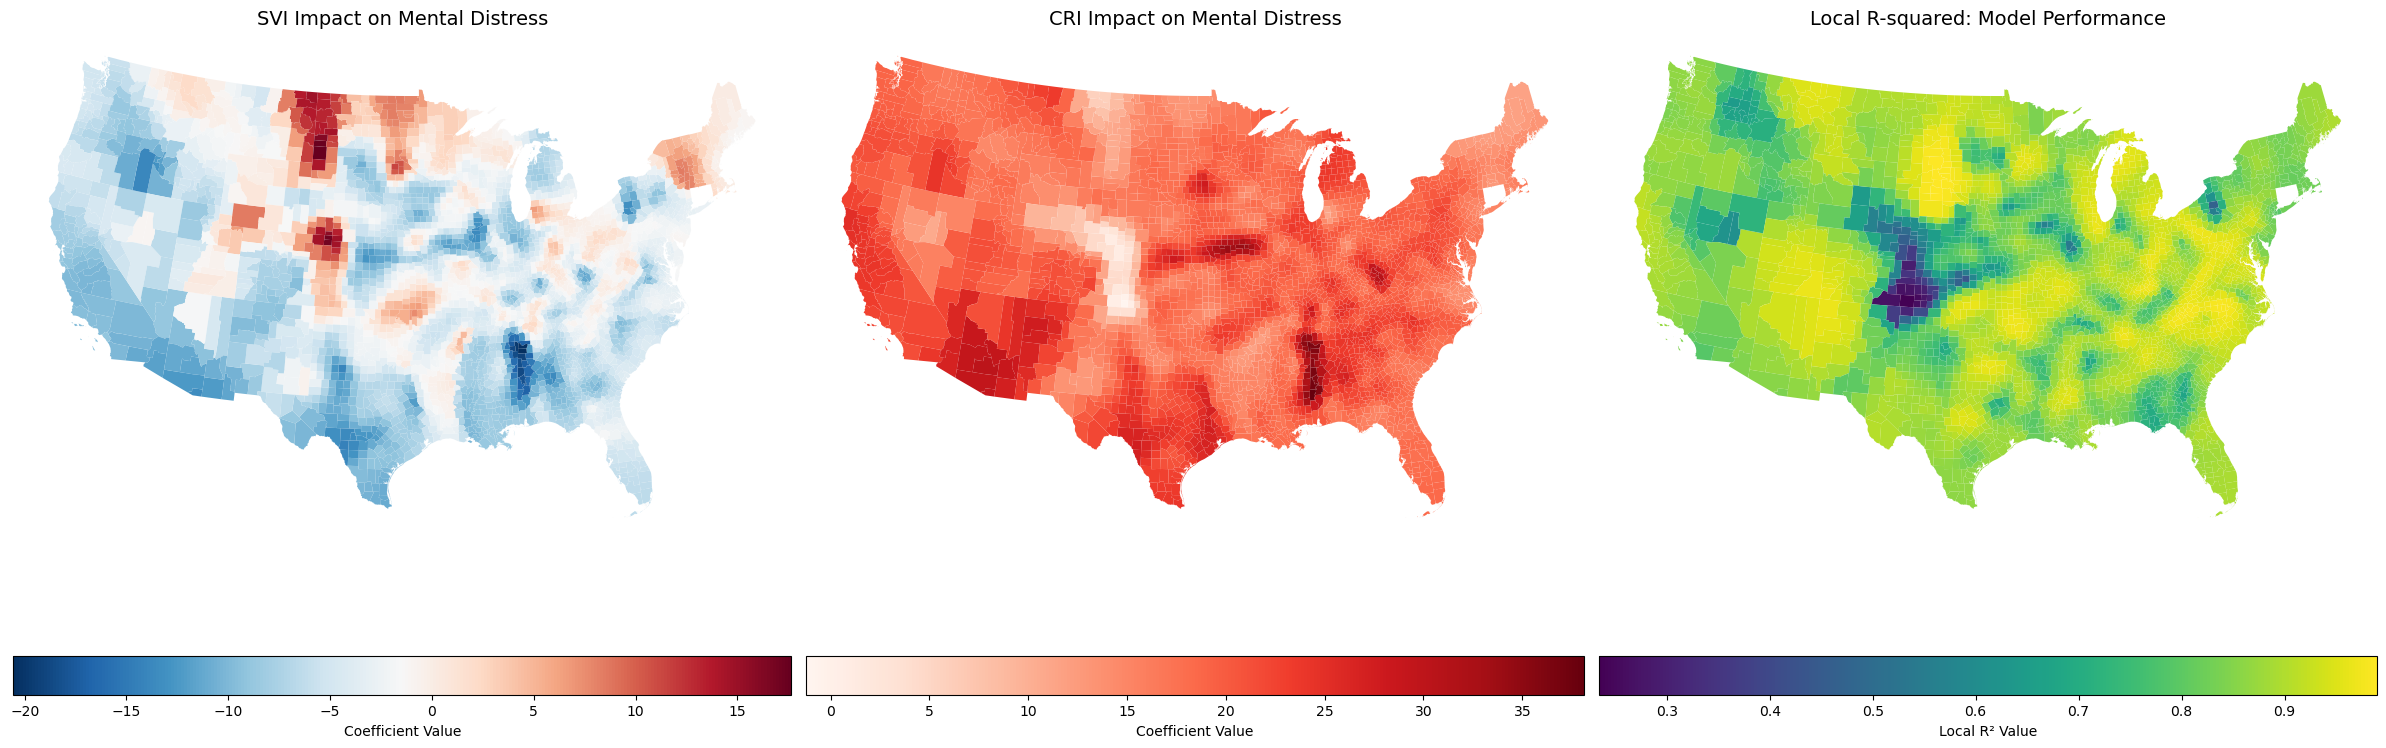

In [50]:
# Add Mental Distress GWR results to dataframe
contiguous_us_proj['gwr_svi_coef_mentdist'] = gwr_results_mentdist.params[:, 1]
contiguous_us_proj['gwr_cri_coef_mentdist'] = gwr_results_mentdist.params[:, 2]
contiguous_us_proj['gwr_local_r2_mentdist'] = gwr_results_mentdist.localR2

# Create subplots for Mental Distress GWR results
fig, axes = plt.subplots(1, 3, figsize=(24, 8))

# SVI Coefficient for Mental Distress
contiguous_us_proj.plot(column='gwr_svi_coef_mentdist', cmap='RdBu_r', legend=True,
                       legend_kwds={'label': "Coefficient Value", 'orientation': "horizontal"},
                       ax=axes[0])
axes[0].set_axis_off()
axes[0].set_title('SVI Impact on Mental Distress', fontsize=14)

# CRI Coefficient for Mental Distress
contiguous_us_proj.plot(column='gwr_cri_coef_mentdist', cmap='Reds', legend=True,
                       legend_kwds={'label': "Coefficient Value", 'orientation': "horizontal"},
                       ax=axes[1])
axes[1].set_axis_off()
axes[1].set_title('CRI Impact on Mental Distress', fontsize=14)

# Local R-squared for Mental Distress
contiguous_us_proj.plot(column='gwr_local_r2_mentdist', cmap='viridis', legend=True,
                       legend_kwds={'label': "Local R² Value", 'orientation': "horizontal"},
                       ax=axes[2])
axes[2].set_axis_off()
axes[2].set_title('Local R-squared: Model Performance', fontsize=14)

plt.tight_layout()
plt.show()


1. IDENTIFYING HOTSPOTS FOR BOTH OUTCOMES...


/cvmfs/cybergis.illinois.edu/software/conda/cybergisx/python3-0.9.4/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 5 disconnected components.
 There are 4 islands with ids: 1257, 1261, 2045, 2922.
  warnings.warn(message)


('WARNING: ', 1257, ' is an island (no neighbors)')
('WARNING: ', 1261, ' is an island (no neighbors)')
('WARNING: ', 2045, ' is an island (no neighbors)')
('WARNING: ', 2922, ' is an island (no neighbors)')


/cvmfs/cybergis.illinois.edu/software/conda/cybergisx/python3-0.9.4/lib/python3.8/site-packages/esda/moran.py:1057: RuntimeWarning: invalid value encountered in true_divide
  self.z_sim = (self.Is - self.EI_sim) / self.seI_sim
/cvmfs/cybergis.illinois.edu/software/conda/cybergisx/python3-0.9.4/lib/python3.8/site-packages/esda/moran.py:1057: RuntimeWarning: invalid value encountered in true_divide
  self.z_sim = (self.Is - self.EI_sim) / self.seI_sim


   Depression hotspots: 1329 counties
   Mental distress hotspots: 1201 counties

2. CALIBRATING SPATIAL MODELS...
   GWR models calibrated successfully

3. RUNNING SEPARATE MONTE CARLO SIMULATIONS...
   Progress: 0/1000 iterations
   Progress: 20/1000 iterations
   Progress: 40/1000 iterations
   Progress: 60/1000 iterations
   Progress: 80/1000 iterations
   Progress: 100/1000 iterations
   Progress: 120/1000 iterations
   Progress: 140/1000 iterations
   Progress: 160/1000 iterations
   Progress: 180/1000 iterations
   Progress: 200/1000 iterations
   Progress: 220/1000 iterations
   Progress: 240/1000 iterations
   Progress: 260/1000 iterations
   Progress: 280/1000 iterations
   Progress: 300/1000 iterations
   Progress: 320/1000 iterations
   Progress: 340/1000 iterations
   Progress: 360/1000 iterations
   Progress: 380/1000 iterations
   Progress: 400/1000 iterations
   Progress: 420/1000 iterations
   Progress: 440/1000 iterations
   Progress: 460/1000 iterations
   Progress: 

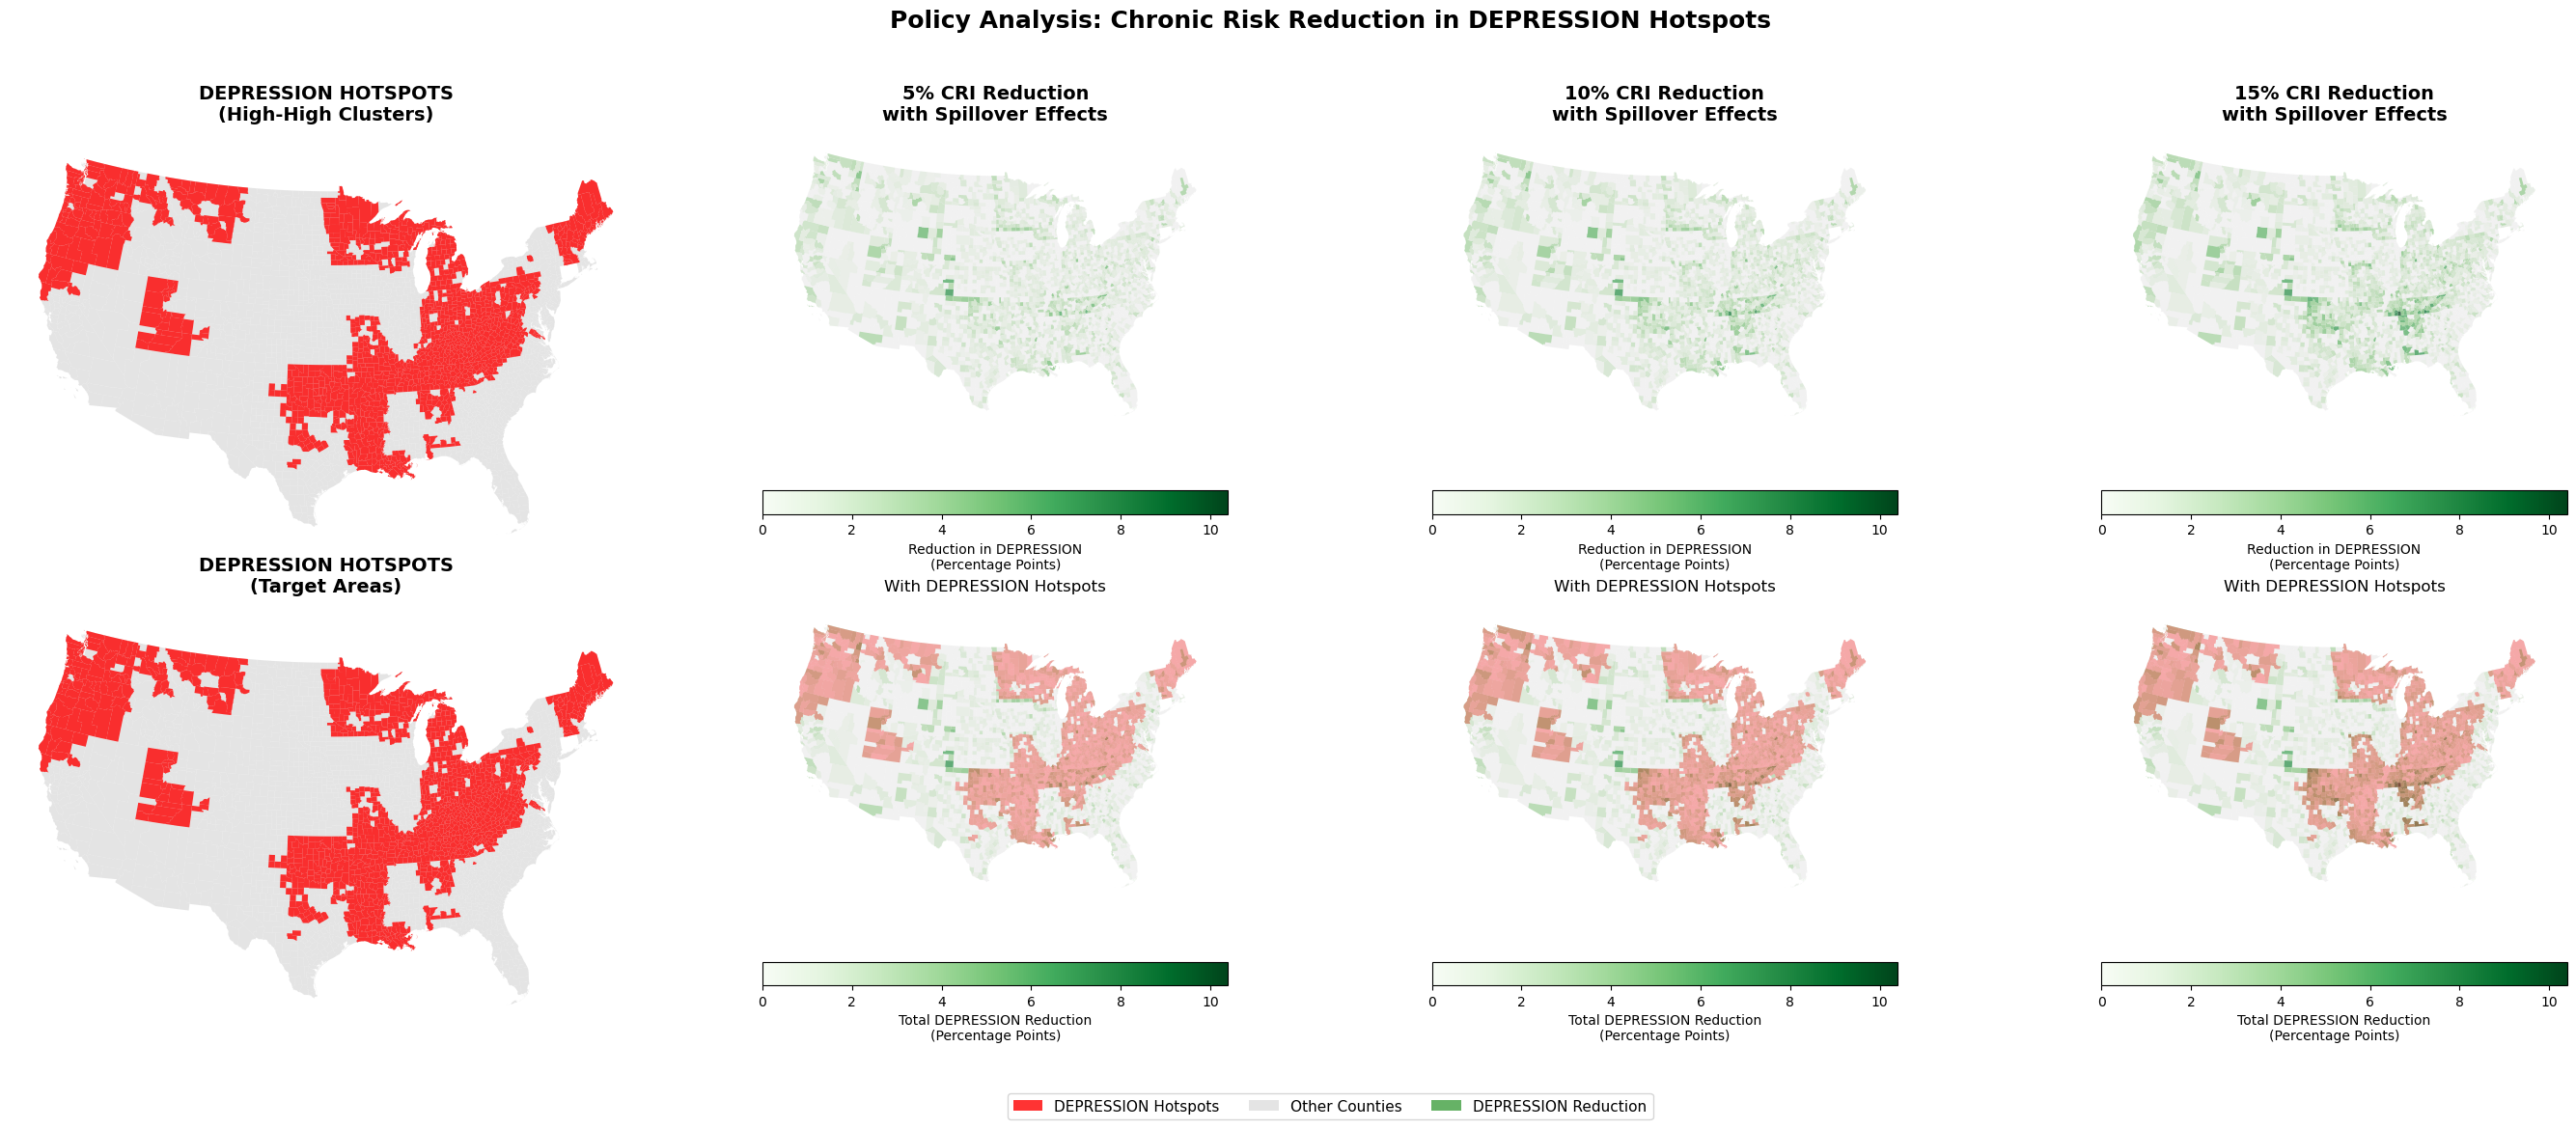

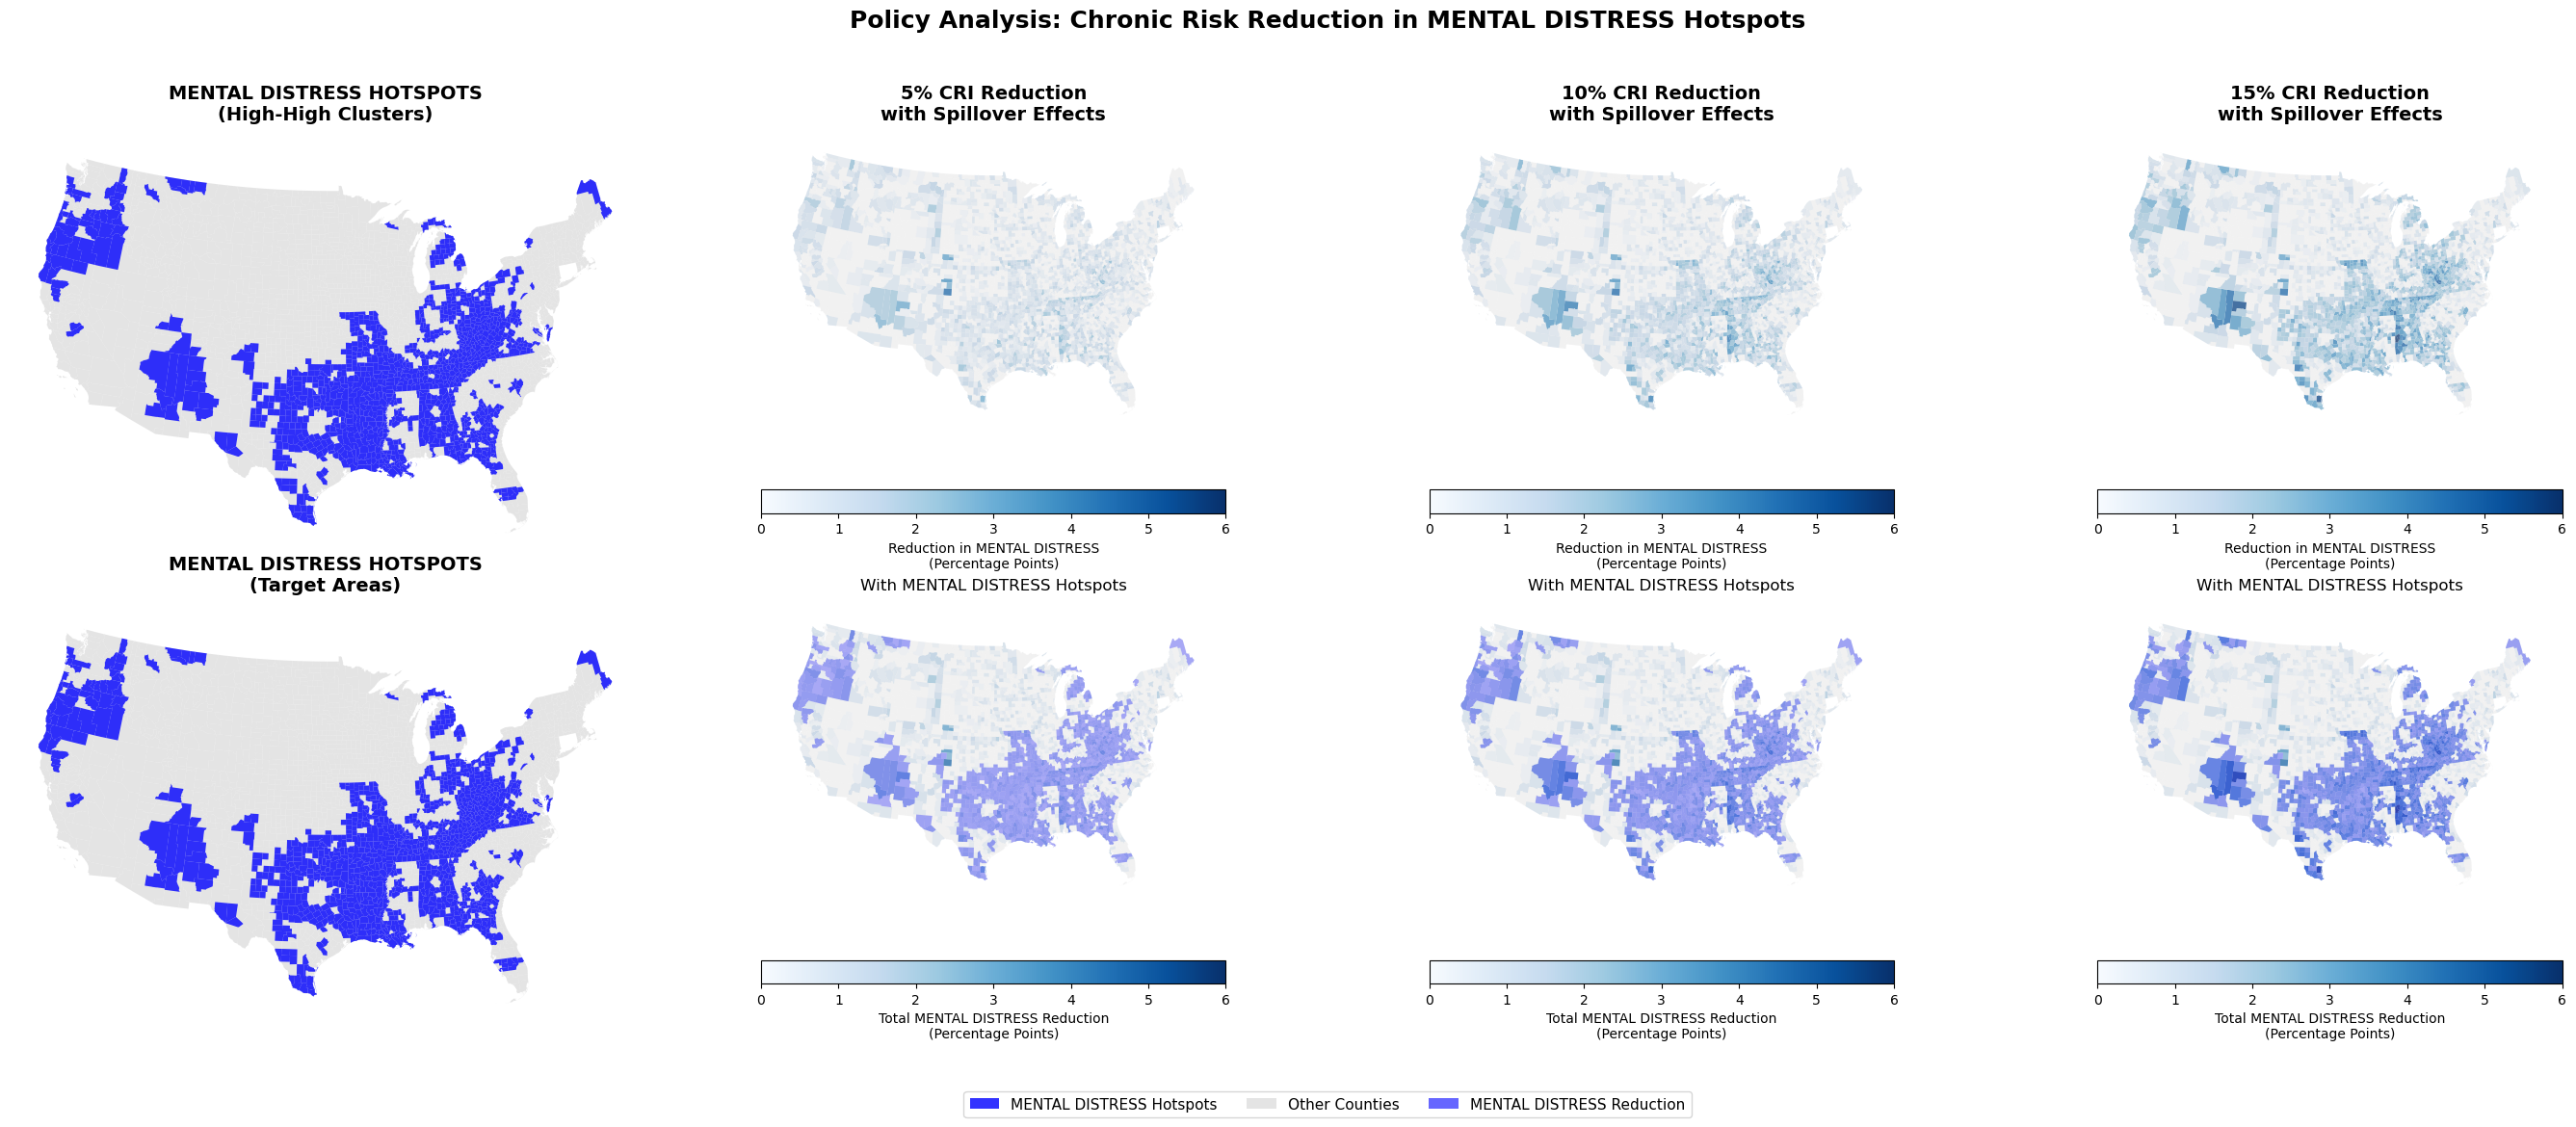


MONTE CARLO SIMULATION RESULTS

DEPRESSION HOTSPOTS INTERVENTION:
     Intervention  Target Areas Avg Reduction           95% CI Counties Benefiting
 5% CRI Reduction 1329 Hotspots       0.6364% [0.5073, 0.7523]                1773
10% CRI Reduction 1329 Hotspots       0.9903% [0.8634, 1.1058]                1874
15% CRI Reduction 1329 Hotspots       1.3441% [1.2187, 1.4573]                1925

MENTAL DISTRESS HOTSPOTS INTERVENTION:
     Intervention  Target Areas Avg Reduction           95% CI Counties Benefiting
 5% CRI Reduction 1201 Hotspots       0.6262% [0.5418, 0.7123]                1952
10% CRI Reduction 1201 Hotspots       1.1579% [1.0744, 1.2425]                2050
15% CRI Reduction 1201 Hotspots       1.6897% [1.6075, 1.7733]                2068


In [61]:
# MONTE CARLO SIMULATION FOR BOTH OUTCOMES
# LISA CLUSTER ANALYSIS FOR BOTH OUTCOMES ---
print("\n1. IDENTIFYING HOTSPOTS FOR BOTH OUTCOMES...")
w = Queen.from_dataframe(contiguous_us_proj)
w.transform = 'r'

# LISA for depression
moran_local_depress = Moran_Local(contiguous_us_proj['depress'], w)
contiguous_us_proj['lisa_q_depress'] = moran_local_depress.q
contiguous_us_proj['lisa_p_depress'] = moran_local_depress.p_sim

# LISA for mental distress
moran_local_mentdist = Moran_Local(contiguous_us_proj['mentdist'], w)
contiguous_us_proj['lisa_q_mentdist'] = moran_local_mentdist.q
contiguous_us_proj['lisa_p_mentdist'] = moran_local_mentdist.p_sim

depress_hotspots = contiguous_us_proj['lisa_q_depress'] == 1
mentdist_hotspots = contiguous_us_proj['lisa_q_mentdist'] == 1

print(f"   Depression hotspots: {depress_hotspots.sum()} counties")
print(f"   Mental distress hotspots: {mentdist_hotspots.sum()} counties")

#  GWR MODEL 
print("\n2. CALIBRATING SPATIAL MODELS...")
coords = np.vstack([contiguous_us_proj.geometry.centroid.x, contiguous_us_proj.geometry.centroid.y]).T

# Depression model
y_depress = contiguous_us_proj['depress'].values.reshape(-1, 1)
X_depress = contiguous_us_proj[['svi', 'cri']].values
X_depress = np.hstack([np.ones(y_depress.shape), X_depress])

# Mental distress model  
y_mentdist = contiguous_us_proj['mentdist'].values.reshape(-1, 1)
X_mentdist = contiguous_us_proj[['svi', 'cri']].values
X_mentdist = np.hstack([np.ones(y_mentdist.shape), X_mentdist])

# Fit GWR models
selector_depress = Sel_BW(coords, y_depress, X_depress)
bw_depress = selector_depress.search()
gwr_model_depress = GWR(coords, y_depress, X_depress, bw=bw_depress)
gwr_results_depress = gwr_model_depress.fit()

selector_mentdist = Sel_BW(coords, y_mentdist, X_mentdist)
bw_mentdist = selector_mentdist.search()
gwr_model_mentdist = GWR(coords, y_mentdist, X_mentdist, bw=bw_mentdist)
gwr_results_mentdist = gwr_model_mentdist.fit()

print("   GWR models calibrated successfully")

# MONTE CARLO SIMULATIONS
print("\n3. RUNNING SEPARATE MONTE CARLO SIMULATIONS...")
n_simulations = 1000 #(User can change if needed more iteration)
reductions = [0.05, 0.10, 0.15]

# Store results separately for each outcome
mc_results_depress = {f'{int(r*100)}%': [] for r in reductions}
mc_results_mentdist = {f'{int(r*100)}%': [] for r in reductions}

for sim in range(n_simulations):
    if sim % 20 == 0:
        print(f"   Progress: {sim}/{n_simulations} iterations")
    
    # Parameter uncertainty
    depress_coef_noise = gwr_results_depress.params * np.random.normal(1, 0.1, gwr_results_depress.params.shape)
    mentdist_coef_noise = gwr_results_mentdist.params * np.random.normal(1, 0.1, gwr_results_mentdist.params.shape)
    
    for reduction in reductions:
        # DEPRESSION: Target depression hotspots
        X_sim_depress = X_depress.copy()
        X_sim_depress[depress_hotspots, 2] = X_sim_depress[depress_hotspots, 2] * (1 - reduction)
        sim_depress = np.sum(depress_coef_noise * X_sim_depress, axis=1)
        depress_reduction = contiguous_us_proj['depress'] - sim_depress
        mc_results_depress[f'{int(reduction*100)}%'].append(depress_reduction[depress_hotspots].mean())
        
        # MENTAL DISTRESS: Target mental distress hotspots
        X_sim_mentdist = X_mentdist.copy()
        X_sim_mentdist[mentdist_hotspots, 2] = X_sim_mentdist[mentdist_hotspots, 2] * (1 - reduction)
        sim_mentdist = np.sum(mentdist_coef_noise * X_sim_mentdist, axis=1)
        mentdist_reduction = contiguous_us_proj['mentdist'] - sim_mentdist
        mc_results_mentdist[f'{int(reduction*100)}%'].append(mentdist_reduction[mentdist_hotspots].mean())

# SEPARATE SPILLOVER CALCULATIONS
print("\n4. CALCULATING SEPARATE SPATIAL SPILLOVERS...")

def calculate_spillover_effects(base_reductions, weight_matrix, decay_factor=0.3):
    w_dense = weight_matrix.toarray()
    spillovers = w_dense * base_reductions.values.reshape(-1, 1) * decay_factor
    return spillovers.sum(axis=1)

# Calculate impacts for each outcome targeting its own hotspots
for reduction in reductions:
    # DEPRESSION: Target depression hotspots
    X_sim_depress = X_depress.copy()
    X_sim_depress[depress_hotspots, 2] = X_sim_depress[depress_hotspots, 2] * (1 - reduction)
    sim_depress = np.sum(gwr_results_depress.params * X_sim_depress, axis=1)
    contiguous_us_proj[f'depress_reduction_{int(reduction*100)}pct'] = contiguous_us_proj['depress'] - sim_depress
    
    depress_spillover = calculate_spillover_effects(
        contiguous_us_proj[f'depress_reduction_{int(reduction*100)}pct'], w.sparse, 0.3)
    contiguous_us_proj[f'depress_total_{int(reduction*100)}pct'] = (
        contiguous_us_proj[f'depress_reduction_{int(reduction*100)}pct'] + depress_spillover)
    
    # MENTAL DISTRESS: Target mental distress hotspots
    X_sim_mentdist = X_mentdist.copy()
    X_sim_mentdist[mentdist_hotspots, 2] = X_sim_mentdist[mentdist_hotspots, 2] * (1 - reduction)
    sim_mentdist = np.sum(gwr_results_mentdist.params * X_sim_mentdist, axis=1)
    contiguous_us_proj[f'mentdist_reduction_{int(reduction*100)}pct'] = contiguous_us_proj['mentdist'] - sim_mentdist
    
    mentdist_spillover = calculate_spillover_effects(
        contiguous_us_proj[f'mentdist_reduction_{int(reduction*100)}pct'], w.sparse, 0.3)
    contiguous_us_proj[f'mentdist_total_{int(reduction*100)}pct'] = (
        contiguous_us_proj[f'mentdist_reduction_{int(reduction*100)}pct'] + mentdist_spillover)

#  VISUALIZATIONS FOR EACH OUTCOME
print("\n5. GENERATING SEPARATE VISUALIZATIONS...")

# Create two separate 2x4 figures - one for each outcome
outcome_configs = [
    {'hotspots': depress_hotspots, 'name': 'depress', 'display_name': 'DEPRESSION', 'color': 'red', 'cmap': 'Greens'},
    {'hotspots': mentdist_hotspots, 'name': 'mentdist', 'display_name': 'MENTAL DISTRESS', 'color': 'blue', 'cmap': 'Blues'}
]

for config in outcome_configs:
    hotspots_mask = config['hotspots']
    outcome_name = config['name']
    display_name = config['display_name']
    color = config['color']
    cmap = config['cmap']
    
    fig, axes = plt.subplots(2, 4, figsize=(28, 12))
    
    # Find scale for this outcome
    outcome_vmax = 0
    for reduction in reductions:
        total_impact = contiguous_us_proj[f'{outcome_name}_total_{int(reduction*100)}pct']
        outcome_vmax = max(outcome_vmax, total_impact.max())
    outcome_vmax = round(outcome_vmax, 1)
    
    # COLUMN 1: HOTSPOTS
    contiguous_us_proj.plot(ax=axes[0,0], color='lightgray', alpha=0.6)
    hotspots = contiguous_us_proj[hotspots_mask]
    hotspots.plot(ax=axes[0,0], color=color, alpha=0.8)
    axes[0,0].set_axis_off()
    axes[0,0].set_title(f'{display_name} HOTSPOTS\n(High-High Clusters)', fontsize=14, weight='bold', pad=15)
    
    # Second row - same hotspots
    contiguous_us_proj.plot(ax=axes[1,0], color='lightgray', alpha=0.6)
    hotspots.plot(ax=axes[1,0], color=color, alpha=0.8)
    axes[1,0].set_axis_off()
    axes[1,0].set_title(f'{display_name} HOTSPOTS\n(Target Areas)', fontsize=14, weight='bold', pad=15)
    
    # COLUMNS 2-4: INTERVENTION SCENARIOS
    scenario_details = {
        '5%': '5% CRI Reduction\nwith Spillover Effects',
        '10%': '10% CRI Reduction\nwith Spillover Effects', 
        '15%': '15% CRI Reduction\nwith Spillover Effects'
    }
    
    for i, reduction in enumerate(reductions):
        col_idx = i + 1
        
        # Direct impacts (top row)
        total_impact = contiguous_us_proj[f'{outcome_name}_total_{int(reduction*100)}pct']
        positive_impact = contiguous_us_proj[total_impact > 0]
        
        if len(positive_impact) > 0:
            positive_impact.plot(column=f'{outcome_name}_total_{int(reduction*100)}pct', 
                                cmap=cmap, legend=True, ax=axes[0,col_idx], 
                                vmin=0, vmax=outcome_vmax,
                                legend_kwds={'label': f'Reduction in {display_name}\n(Percentage Points)',
                                           'orientation': 'horizontal', 'shrink': 0.7})
        
        contiguous_us_proj.plot(ax=axes[0,col_idx], color='lightgray', alpha=0.3)
        axes[0,col_idx].set_axis_off()
        axes[0,col_idx].set_title(f'{scenario_details[f"{int(reduction*100)}%"]}', fontsize=14, weight='bold', pad=15)
        
        # Total impacts with hotspots (bottom row)
        if len(positive_impact) > 0:
            positive_impact.plot(column=f'{outcome_name}_total_{int(reduction*100)}pct', 
                                cmap=cmap, legend=True, ax=axes[1,col_idx], 
                                vmin=0, vmax=outcome_vmax,
                                legend_kwds={'label': f'Total {display_name} Reduction\n(Percentage Points)',
                                           'orientation': 'horizontal', 'shrink': 0.7})
        
        contiguous_us_proj.plot(ax=axes[1,col_idx], color='lightgray', alpha=0.3)
        hotspots.plot(ax=axes[1,col_idx], color=color, alpha=0.3)
        axes[1,col_idx].set_axis_off()
        axes[1,col_idx].set_title(f'With {display_name} Hotspots', fontsize=12, pad=15)
    
    # Add legend
    legend_elements = [
        Patch(facecolor=color, alpha=0.8, label=f'{display_name} Hotspots'),
        Patch(facecolor='lightgray', alpha=0.6, label='Other Counties'),
        Patch(facecolor='green' if display_name == 'DEPRESSION' else 'blue', alpha=0.6, 
              label=f'{display_name} Reduction')
    ]
    
    fig.legend(handles=legend_elements, loc='upper center', 
               bbox_to_anchor=(0.5, 0.02), ncol=3, fontsize=11, frameon=True)
    
    plt.suptitle(f'Policy Analysis: Chronic Risk Reduction in {display_name} Hotspots', 
                 fontsize=18, weight='bold', y=0.95)
    plt.tight_layout(rect=[0, 0.05, 1, 0.93])
    plt.show()

# COMPREHENSIVE RESULTS for interpretion
print("\n" + "="*100)
print("MONTE CARLO SIMULATION RESULTS")
print("="*100)

# Depression results
print("\nDEPRESSION HOTSPOTS INTERVENTION:")
results_depress = []
for reduction in reductions:
    key = f'{int(reduction*100)}%'
    vals = mc_results_depress[key]
    total_impact = contiguous_us_proj[f'depress_total_{int(reduction*100)}pct']
    counties_benefiting = (total_impact > 0).sum()
    
    results_depress.append({
        'Intervention': f'{key} CRI Reduction',
        'Target Areas': f'{depress_hotspots.sum()} Hotspots',
        'Avg Reduction': f'{np.mean(vals):.4f}%',
        '95% CI': f'[{np.percentile(vals, 2.5):.4f}, {np.percentile(vals, 97.5):.4f}]',
        'Counties Benefiting': f'{counties_benefiting}'
    })

depress_df = pd.DataFrame(results_depress)
print(depress_df.to_string(index=False))

# Mental distress results
print("\nMENTAL DISTRESS HOTSPOTS INTERVENTION:")
results_mentdist = []
for reduction in reductions:
    key = f'{int(reduction*100)}%'
    vals = mc_results_mentdist[key]
    total_impact = contiguous_us_proj[f'mentdist_total_{int(reduction*100)}pct']
    counties_benefiting = (total_impact > 0).sum()
    
    results_mentdist.append({
        'Intervention': f'{key} CRI Reduction',
        'Target Areas': f'{mentdist_hotspots.sum()} Hotspots',
        'Avg Reduction': f'{np.mean(vals):.4f}%',
        '95% CI': f'[{np.percentile(vals, 2.5):.4f}, {np.percentile(vals, 97.5):.4f}]',
        'Counties Benefiting': f'{counties_benefiting}'
    })

mentdist_df = pd.DataFrame(results_mentdist)
print(mentdist_df.to_string(index=False))